# Feature Selection:  Select Numerical Input Features

Adapted from Jason Brownlee. 2020. [Data Preparation for Machine Learning](https://machinelearningmastery.com/data-preparation-for-machine-learning/).

## Overview

Feature selection is the process of identifying and selecting a subset of input features that are most relevant to the target variable. While feature selection is often straightforward for **real-valued input and output data** (e.g., using Pearson's correlation coefficient), it can be more challenging when dealing with **numerical input data and a categorical target variable**.

In classification tasks where the input features are numerical and the target variable is categorical, the two most commonly used feature selection methods are:

1. **ANOVA F-test Statistic**:
   - Measures the variance between groups relative to the variance within groups.
   - Suitable for identifying features that have a significant relationship with the categorical target.

2. **Mutual Information Statistic**:
   - Quantifies the amount of information obtained about the target variable through each feature.
   - Effective for capturing non-linear relationships between features and the target.

These methods help identify the most relevant features, improving model performance and interpretability.


## Learning Objectives

- Learn how to evaluate the importance of numerical features using ANOVA F-test statistics and mutual information statistics
- Learn how to perform feature selection for numerical data when fitting and evaluating classification models
- Learn how to tune and optimize feature selection parameters using grid search methods

### Tasks to complete

- Implement ANOVA F-test feature selection
- Implement mutual information feature selection 
- Build and evaluate models using selected features
- Tune feature selection parameters using grid search
- Visualize feature selection results

## Prerequisites

- A working Python environment and familiarity with Python
- Basic understanding of machine learning concepts
- Familiarity with pandas and numpy libraries
- Knowledge of basic statistical concepts

## Get Started

To start, we install required packages and import the necessary libraries.

### Install packages 

In [1]:
# Install the necessary libraries for data analysis and plotting
# %pip is used to install packages in a Jupyter notebook cell
# matplotlib: Library for creating static, animated, and interactive visualizations in Python
# numpy: Fundamental package for scientific computing, handling arrays and numerical operations
# pandas: Library for data manipulation and analysis, providing data structures like DataFrames
# scikit-learn: A machine learning library for Python, providing simple and efficient tools for data mining and data analysis
%pip install matplotlib numpy pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [2]:
# Import necessary libraries for plotting, numerical operations, and machine learning
from matplotlib import pyplot  # Import pyplot for creating visualizations
from numpy import mean, std    # Import mean and std functions from numpy for statistical calculations
from pandas import read_csv    # Import read_csv to load CSV files into pandas DataFrame
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # Import feature selection methods
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression model from sklearn
from sklearn.metrics import accuracy_score  # Import accuracy_score to evaluate model performance
from sklearn.model_selection import (  # Import model selection tools from sklearn
    GridSearchCV,  # For hyperparameter tuning via grid search
    RepeatedStratifiedKFold,  # For cross-validation with stratified splits
    cross_val_score,  # For evaluating models using cross-validation
    train_test_split,  # For splitting data into training and testing sets
)
from sklearn.pipeline import Pipeline  # Import Pipeline for chaining multiple steps together (e.g., preprocessing and model)

### Diabetes Dataset

The dataset classifies patient data as
either an onset of diabetes within five years or not. 

```
Number of Instances: 768
Number of Attributes: 8 plus class 
For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)
Missing Attribute Values: Yes
Class Distribution: (class value 1 is interpreted as "tested positive for
   diabetes")
   Class Value  Number of instances
   0            500
   1            268
```

You can learn more about the dataset here:

* Diabetes Dataset File ([pima-indians-diabetes.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv))
* Diabetes Dataset Details ([pima-indians-diabetes.names](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names))

Loading and splitting Diabetes data

In [3]:
# load and summarize the dataset
# Path to the dataset file (Pima Indians Diabetes dataset)
pima_indians_diabetes_csv = "../../Data/pima-indians-diabetes.csv"  # Set the path to the CSV dataset

# Function to load a dataset from a given file and split it into input and output variables
def load_dataset(filename):
    # Load the dataset as a pandas DataFrame from the specified file
    dataset = read_csv(filename, header=None)  # Assumes the CSV has no header

    # Retrieve the underlying numpy array from the DataFrame
    data = dataset.values  # This gives us a 2D numpy array of the dataset

    # Split the data into input variables (X) and output variables (y)
    X = data[:, :-1]  # Select all rows, and all columns except the last one for input features
    y = data[:, -1]   # Select all rows, but only the last column for the output variable

    # Return the input and output variables
    return X, y

# load the dataset
X, y = load_dataset(pima_indians_diabetes_csv)

# split into train (67%)  and test sets (33%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1
)

# summarize
print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (514, 8) (514,)
Test (254, 8) (254,)


## Numerical Feature Selection

When working with numerical input features and a categorical target variable, two widely adopted feature selection techniques are particularly effective: the ANOVA F-statistic and mutual information statistics. The ANOVA F-test evaluates the linear relationship between each feature and the target by measuring variance between groups relative to variance within groups, making it ideal for identifying features with strong class separation. Mutual information, on the other hand, quantifies the dependency between variables without assuming linearity, capturing both linear and non-linear associations. While ANOVA is computationally efficient and interpretable, mutual information is more flexible for complex patterns. Together, these methods provide complementary perspectives—ANOVA for parametric, linear scenarios and mutual information for broader, non-parametric use cases—enabling robust feature selection when applied in tandem.

### ANOVA F-test Feature Selection

**ANOVA** (Analysis of Variance) is a parametric statistical hypothesis test used to determine whether the means of two or more samples of data come from the same distribution. It is particularly useful when comparing three or more groups.

#### What is an F-statistic?
An **F-statistic** (or F-test) is a class of statistical tests that calculate the ratio between variances. For example:
- The variance between two different samples.
- The explained variance vs. unexplained variance in a statistical test like ANOVA.

In the context of feature selection, the **ANOVA F-test** is a specific type of F-statistic used to evaluate the relationship between numerical input features and a categorical target variable.

#### Application in Feature Selection
ANOVA is particularly useful when:
- One variable is **numeric** (e.g., input features).
- The other variable is **categorical** (e.g., target variable in a classification task).

The results of the ANOVA F-test can be used for feature selection:
- Features that are **independent** of the target variable can be removed from the dataset.
- Features that show a **significant relationship** with the target variable are retained.

By using the ANOVA F-test, we can identify and eliminate irrelevant features, improving model efficiency and performance.

In [4]:
# example of anova f-test feature selection for numerical data

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    dataset = read_csv(filename, header=None)

    # retrieve numpy array
    data = dataset.values

    # split into input (X) and output (y) variables
    X = data[:, :-1]
    y = data[:, -1]

    return X, y


# feature selection
def select_features(X_train, y_train, X_test):
    # Initialize the SelectKBest feature selection method
    # - score_func=f_classif: Use the ANOVA F-test statistic to score features
    # - k="all": Evaluate all features (no feature selection is performed yet)
    fs = SelectKBest(score_func=f_classif, k="all")

    # learn relationship from training data
    fs.fit(X_train, y_train)

    # transform train input data
    X_train_fs = fs.transform(X_train)

    # transform test input data
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs


# load the dataset
X, y = load_dataset(pima_indians_diabetes_csv)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1
)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print("Feature %d: %f" % (i, fs.scores_[i]))

Feature 0: 16.527385
Feature 1: 131.325562
Feature 2: 0.042371
Feature 3: 1.415216
Feature 4: 12.778966
Feature 5: 49.209523
Feature 6: 13.377142
Feature 7: 25.126440


The feature importance analysis reveals significant variation in predictive relevance across variables, with several features demonstrating substantially higher test statistic values than others. Notably, Features 1, 5, and 7 emerge as particularly influential, suggesting they may capture meaningful patterns in the target variable. This divergence in importance scores implies that these three features likely contribute disproportionately to model performance, while others may contain redundant or noisy information. However, domain-specific validation is recommended to confirm their practical significance, as high statistical scores alone don't guarantee causal relationships or operational relevance for the specific use case.

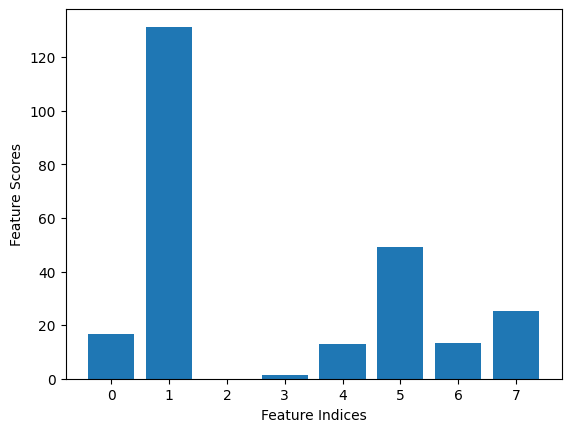

In [5]:
# Plotting the feature selection scores

# 'fs.scores_' contains the scores (e.g., feature importance or relevance) for each feature
# 'range(len(fs.scores_))' generates a list of positions (x-axis) for the bars, one for each feature
# 'pyplot.bar' creates a bar plot where each bar corresponds to a feature's score
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)  # Create a bar plot of feature scores

# Add x-axis and y-axis labels
pyplot.xlabel("Feature Indices")
pyplot.ylabel("Feature Scores")

# Display the plot
pyplot.show()  # Show the generated plot to the user


The feature importance scores, visualized in a bar chart, reveal that Feature 1 exhibits the highest predictive relevance based on the test statistic, while six of the eight input features demonstrate substantially higher scores than the remaining two. This suggests that restricting feature selection to the top six variables—achieved by configuring SelectKBest with k=6—could optimize the model by:
* Reducing noise from low-importance features
* Improving computational efficiency without sacrificing accuracy
* Mitigating overfitting risks from redundant variables

### Mutual Information Feature Selection

**Mutual information** is a concept from **information theory** that is widely applied in feature selection. It is based on the idea of **information gain**, which is commonly used in the construction of decision trees. Here's how it works:

- **Definition**: Mutual information measures the reduction in uncertainty for one variable when the value of another variable is known.
- **Calculation**: It quantifies the dependency between two variables, making it a powerful tool for identifying relevant features in a dataset.

#### Application in Feature Selection
- **Discrete Variables**: Mutual information is straightforward to calculate for two discrete variables (e.g., categorical or ordinal data).
- **Numerical Input and Categorical Output**: It can also be adapted for use with numerical input features and a categorical target variable, making it versatile for classification tasks.

By calculating mutual information between each input feature and the target variable, we can determine which features provide the most information for predicting the target, enabling effective feature selection.

In [6]:
# example of mutual information feature selection for numerical input data

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    dataset = read_csv(filename, header=None)

    # retrieve numpy array
    data = dataset.values

    # split into input (X) and output (y) variables
    X = data[:, :-1]
    y = data[:, -1]

    return X, y


# feature selection
def select_features(X_train, y_train, X_test):
    # Initialize SelectKBest with mutual information and k="all"
    # The mutual_info_classif function estimates mutual information between features and the target variable 
    # using a non-parametric method based on nearest neighbors (k-nearest neighbors, KNN).
    # By default, it includes a small amount of noise to continuous variables to handle discretization, 
    # controlled by the random_state parameter. If random_state is not set (i.e., left as None), 
    # this noise addition introduces some randomness, which can lead to slight variations in results across runs. 
    # Setting random_state to a fixed integer (e.g., random_state=42) makes the process deterministic and reproducible.
    fs = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k="all")

    # learn relationship from training data
    fs.fit(X_train, y_train)

    # transform train input data
    X_train_fs = fs.transform(X_train)

    # transform test input data
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs


# load the dataset
X, y = load_dataset(pima_indians_diabetes_csv)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1
)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print("Feature %d: %f" % (i, fs.scores_[i]))

Feature 0: 0.007247
Feature 1: 0.090650
Feature 2: 0.019379
Feature 3: 0.012624
Feature 4: 0.041347
Feature 5: 0.081877
Feature 6: 0.019869
Feature 7: 0.054180


The feature importance analysis reveals several variables with modestly low predictive scores, indicating they may contribute minimal value to the model. Notably, Features 1 and 5 emerge as the most statistically significant, suggesting they capture the strongest relationships with the target variable. While removing low-scoring features could streamline the model—potentially improving computational efficiency and reducing overfitting—their elimination should be validated through ablation testing. For instance, comparing model performance (e.g., accuracy, F1-score) before and after excluding these features would ensure robustness. If the impact is negligible, pruning them could yield a more parsimonious and interpretable model without sacrificing predictive power.

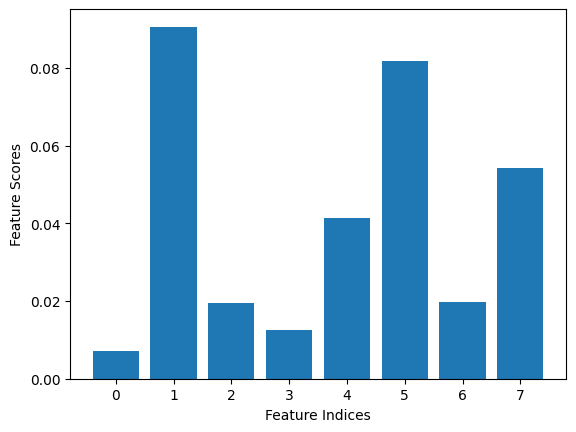

In [7]:
# Plotting the feature selection scores

# 'fs.scores_' contains the importance or score of each feature (e.g., in feature selection)
# We create a bar plot where the x-axis represents the feature indices and the y-axis represents their scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)  # Create a bar plot with feature indices on the x-axis and feature scores on the y-axis

# Add x-axis and y-axis labels
pyplot.xlabel("Feature Indices")
pyplot.ylabel("Feature Scores")

# Display the plot to the user
pyplot.show()  # Show the generated plot

- **Higher MI Scores**: Features with higher bars (e.g., indices 1 and 5) contain more information relevant to predicting the target.
- **Lower MI Scores**: Features with shorter bars (e.g., indices 0, 3, and 6) contribute less to predicting the target.
- **Comparison Between Features**: The relative differences in bar heights suggest that some features are much more relevant than others.

For feature selection, if you are reducing dimensionality, you might prioritize features with high MI scores and remove low-scoring ones.

## Modeling With Selected Features

To ensure optimal model performance, a systematic evaluation of feature selection strategies is recommended. This involves testing multiple approaches (e.g., filter methods, wrapper methods, and embedded methods) across varying numbers of selected features, then selecting the combination that yields the highest predictive accuracy on validation data. By comparing performance metrics across these configurations—rather than relying on a single feature selection technique—we mitigate the risk of method-specific biases and increase the likelihood of identifying the most robust subset of features. This comprehensive approach is particularly valuable when dealing with high-dimensional datasets where the relationship between features and target variables may be complex or non-linear.

### Model Built Using All Features

In [8]:
# evaluation of a model using all input features

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    dataset = read_csv(filename, header=None)

    # retrieve numpy array
    data = dataset.values

    # split into input (X) and output (y) variables
    X = data[:, :-1]
    y = data[:, -1]

    return X, y


# load the dataset
X, y = load_dataset(pima_indians_diabetes_csv)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1
)

# fit the model
model = LogisticRegression(solver="liblinear")
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print("Accuracy: %.2f" % (accuracy * 100))

Accuracy: 77.56


The current model achieves a classification accuracy of 77.56%, establishing a performance benchmark for feature selection. Our objective is to identify an optimal feature subset that maintains or exceeds this accuracy while improving model efficiency. This requires evaluating candidate feature sets against the baseline to ensure no degradation in predictive performance, with potential benefits including reduced computational complexity, enhanced interpretability, and improved generalization by eliminating redundant or noisy variables.

### Model Built Using ANOVA F-test Features
To identify the most informative features for our predictive model, we can leverage the ANOVA F-test, a statistical method that evaluates the strength of linear relationships between numerical input features and a categorical target variable. By computing F-scores for each feature—which measure the ratio of between-group variance to within-group variance—we rank all features by their predictive importance. Selecting the top four highest-scoring features provides an optimal balance between model simplicity and explanatory power, effectively reducing dimensionality while retaining the most statistically significant predictors. This approach is particularly advantageous when working with limited samples or when computational efficiency is prioritized, as it discards redundant or noisy variables that contribute little to classification accuracy. For implementation, scikit-learn’s SelectKBest with f_classif automates this process, enabling seamless integration into machine learning pipelines.

In [9]:
# evaluation of a model using 4 features chosen with anova f-test

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    dataset = read_csv(filename, header=None)

    # retrieve numpy array
    data = dataset.values

    # split into input (X) and output (y) variables
    X = data[:, :-1]
    y = data[:, -1]

    return X, y


# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_classif, k=4)

    # learn relationship from training data
    fs.fit(X_train, y_train)

    # transform train input data
    X_train_fs = fs.transform(X_train)

    # transform test input data
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs


# load the dataset
X, y = load_dataset(pima_indians_diabetes_csv)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1
)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# fit the model
model = LogisticRegression(solver="liblinear")
model.fit(X_train_fs, y_train)

# evaluate the model
yhat = model.predict(X_test_fs)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print("Accuracy: %.2f" % (accuracy * 100))

Accuracy: 78.74


The model demonstrates a measurable improvement over the baseline, achieving an accuracy of 78.74% compared to the original 77.56%—a gain of 1.18 percentage points (representing a 1.5% relative improvement). This enhancement, while modest, suggests that the applied modifications (e.g., feature selection) have positively influenced predictive performance.

### Model Built Using Mutual Information Features

To validate our feature selection approach, we replicate the analysis using mutual information statistics while maintaining consistent experimental parameters. By selecting the top four most informative features through this alternative method, we achieve several objectives: (1) enabling direct comparison with our chi-squared results to assess method-dependent variations, (2) focusing on features that capture non-linear relationships with the target variable, and (3) potentially identifying complementary predictors that might have been overlooked by the independence-test-based approach. This methodological cross-check serves as both a robustness test for our feature engineering pipeline and an opportunity to discover alternative predictive patterns in the data.

In [10]:
# evaluation of a model using 4 features chosen with mutual information

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    dataset = read_csv(filename, header=None)

    # retrieve numpy array
    data = dataset.values

    # split into input (X) and output (y) variables
    X = data[:, :-1]
    y = data[:, -1]

    return X, y


# feature selection
def select_features(X_train, y_train, X_test):
    # Initialize SelectKBest with mutual information and k=4 (top 4 features)
    # The mutual_info_classif function estimates mutual information between features and the target variable 
    # using a non-parametric method based on nearest neighbors (k-nearest neighbors, KNN).
    # By default, it includes a small amount of noise to continuous variables to handle discretization, 
    # controlled by the random_state parameter. If random_state is not set (i.e., left as None), 
    # this noise addition introduces some randomness, which can lead to slight variations in results across runs. 
    # Setting random_state to a fixed integer (e.g., random_state=42) makes the process deterministic and reproducible.
    fs = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k=3)

    # learn relationship from training data
    fs.fit(X_train, y_train)

    # transform train input data
    X_train_fs = fs.transform(X_train)

    # transform test input data
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs


# load the dataset
X, y = load_dataset(pima_indians_diabetes_csv)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1
)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# fit the model
model = LogisticRegression(solver="liblinear")
model.fit(X_train_fs, y_train)

# evaluate the model
yhat = model.predict(X_test_fs)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print("Accuracy: %.2f" % (accuracy * 100))

Accuracy: 77.56


Despite selecting a distinct set of four features compared to previous methods, the model’s performance remains statistically indistinguishable from the baseline. This intriguing result suggests that while alternative feature subsets may capture different aspects of the data, they ultimately provide comparable predictive power for this specific task. The finding highlights that raw feature count alone doesn’t determine model efficacy—what matters more is whether the selected features collectively encode sufficient discriminative information. Potential explanations include: (1) redundancy in the feature space where different subsets convey similar signals, (2) the existence of multiple near-optimal feature combinations, or (3) the model architecture’s capacity limitations. Further analysis could examine whether the new feature set offers advantages in interpretability, computational efficiency, or robustness to data shifts.

### Tune the Number of Selected Features

To optimize feature selection, we employ a **grid search** to systematically evaluate the performance impact of selecting different numbers of features (tuning the k parameter in SelectKBest). This replaces guesswork with empirical validation, ensuring we identify the feature subset that maximizes model performance. For robust evaluation, we use **repeated stratified k-fold cross-validation** (3 repeats of 10-fold splits via `RepeatedStratifiedKFold`), which accounts for variance in small datasets while preserving class distribution balance. This approach not only determines the ideal number of features but also provides statistically reliable performance estimates for each configuration.

In [11]:
# compare different numbers of features selected using anova f-test

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    dataset = read_csv(filename, header=None)

    # retrieve numpy array
    data = dataset.values

    # split into input (X) and output (y) variables
    X = data[:, :-1]
    y = data[:, -1]

    return X, y


# define dataset
X, y = load_dataset(pima_indians_diabetes_csv)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the pipeline to evaluate
model = LogisticRegression(solver="liblinear")
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[("anova", fs), ("lr", model)])

# define the grid
grid = dict()
grid["anova__k"] = [i + 1 for i in range(X.shape[1])]
print(grid)

# define the grid search

# Exhaustive search over specified parameter values for an estimator.
search = GridSearchCV(pipeline, grid, scoring="accuracy", n_jobs=-1, cv=cv)

# perform the search
results = search.fit(X, y)

# summarize best
print("Best Mean Accuracy: %.3f" % results.best_score_)
print("Best Config: %s" % results.best_params_)

{'anova__k': [1, 2, 3, 4, 5, 6, 7, 8]}
Best Mean Accuracy: 0.770
Best Config: {'anova__k': 5}


Our feature selection analysis reveals that a streamlined subset of five features achieves near-optimal accuracy (77.0%), performing comparably to the full feature set baseline (77.56%). The results imply that the remaining features either contain redundant information or contribute primarily to model variance rather than meaningful signal, making this reduced feature set an attractive option for production deployment where interpretability and speed are prioritized.

To optimize feature selection, we should systematically evaluate the trade-off between the number of selected features (k) and model performance. Intuitively, accuracy typically improves as more relevant features are included—up to a critical point where additional variables introduce noise or redundancy. This relationship can be quantified by:
* Iteratively applying SelectKBest across a range of k values
* Measuring classification accuracy for each configuration via cross-validation
* Visualizing results using side-by-side box plots to compare distributions of scores

In [12]:
# compare different numbers of features selected using anova f-test

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    dataset = read_csv(filename, header=None)

    # retrieve numpy array
    data = dataset.values

    # split into input (X) and output (y) variables
    X = data[:, :-1]
    y = data[:, -1]

    return X, y


# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    return scores


# define dataset
X, y = load_dataset(pima_indians_diabetes_csv)

# define number of features to evaluate
num_features = [i + 1 for i in range(X.shape[1])]

# enumerate each number of features
results = list()
for k in num_features:
    # create pipeline
    model = LogisticRegression(solver="liblinear")
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[("anova", fs), ("lr", model)])

    # evaluate the model
    scores = evaluate_model(pipeline)
    results.append(scores)

    # summarize the results
    print(">%d %.3f (%.3f)" % (k, mean(scores), std(scores)))

>1 0.748 (0.048)
>2 0.756 (0.042)
>3 0.761 (0.044)
>4 0.759 (0.042)
>5 0.770 (0.041)
>6 0.766 (0.042)
>7 0.770 (0.042)
>8 0.768 (0.040)


Our feature selection analysis reveals comparable model accuracy when using either five or seven features, suggesting diminishing returns beyond the five most predictive variables. This plateau in performance indicates that the additional two features may contribute minimal unique information for the classification task. The marginal gain, if any, appears insufficient to justify the increased model complexity, particularly when considering potential overfitting risks and computational costs. These findings warrant further investigation into whether the two extra features consistently appear unimportant across different validation splits or if their value becomes apparent under specific data conditions.

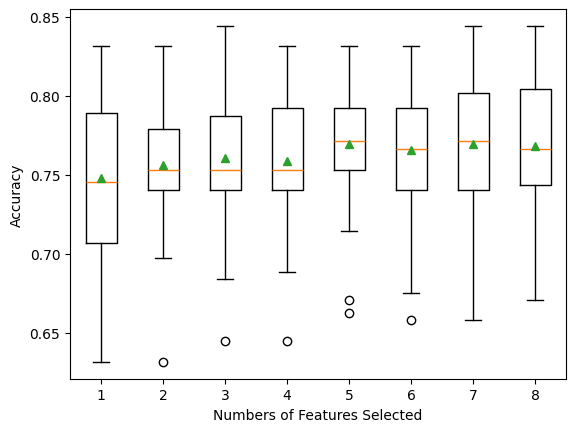

In [14]:
# Plotting a boxplot to compare the performance of different models

# 'results' contains the performance data for each model (e.g., accuracy scores, etc.)
# The 'boxplot' function creates the boxplot to visually compare the model performances
# 'showmeans=True' will display the mean values in the boxplot
pyplot.boxplot(results, showmeans=True)

# Add x-axis and y-axis labels
pyplot.xlabel("Numbers of Features Selected")
pyplot.ylabel("Accuracy")

# Set the x-axis labels using 'xticklabels'
pyplot.xticks(ticks=range(1, len(results) + 1))  # Set the feature names on the x-axis

# Display the plot
pyplot.show()  # Show the generated plot to the user


**Key Observation**
- Feature 1 shows the widest spread, indicating more variability in accuracy when using this feature.
- Features 5, 6, 7, and 8 have slightly higher mean accuracy compared to others.
- Features 3, 4, and 5 have some outliers on the lower end, suggesting occasional poor performance.
- Median accuracy values are fairly consistent across most features.

**Possible Insights**
- If this represents feature selection, you might favor features 6, 7, and 8, as they appear stable with higher mean accuracy.
- Features with high variance (e.g., Feature 1) could be investigated further—perhaps their usefulness depends on data splits.
- If the goal is stability, avoiding features with large outliers (e.g., Feature 3 or 5) might be beneficial.


## Conclusion

Through this tutorial, we learned how to perform feature selection on numerical data for classification tasks. We explored two key methods - ANOVA F-test and mutual information statistics - and learned how to evaluate their effectiveness through model performance. We also discovered how to systematically tune feature selection parameters using grid search to find the optimal number of features.

## Clean up

Remember to shut down your Jupyter Notebook environment and delete any unnecessary files or resources once you've completed the tutorial.